In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')

data = pd.concat([train, test], sort=False)

# 2.4 가설을 기반으로 새로운 feature 만들기

### 2.4.1 재현성

- 결측치를 채울 때 재현성을 고려하는 방법
1. 랜덤한 값을 사용하지 않고 다른 값들을 기반으로 중앙값을 찾아서 넣기
2. 랜덤 값에 seed를 지정해 고정시키기

In [3]:
data['Age'].isnull().sum() 

263

In [4]:
# 랜덤한 값을 사용하는 방법
age_avg = data['Age'].mean()
age_std = data['Age'].std()

data['Age'].fillna(np.random.randint(age_avg-age_std, age_avg+age_std), inplace=True)

In [5]:
# 중앙값을 찾아서 보완하기
data['Age'].fillna(data['Age'].median(), inplace=True)

In [6]:
# 하이퍼파라미터로 seed를 고정하기
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l2', solver='sag', random_state=0)

### 2.4.2 가설을 기반으로 새로운 feature 만들기

- Parch와 SibSp가 일정 값을 넘으면 생존률이 낮아짐
- 이를 더해 '가족 수'라는 feature를 만들고, '예측 성능에 기여할 가능성이 있다'는 가설이 맞는지 확인.

In [7]:
data['SibSp'].value_counts()

SibSp
0    891
1    319
2     42
4     22
3     20
8      9
5      6
Name: count, dtype: int64

In [8]:
data['Parch'].value_counts()

Parch
0    1002
1     170
2     113
3       8
5       6
4       6
6       2
9       2
Name: count, dtype: int64

<Axes: xlabel='FamilySize', ylabel='count'>

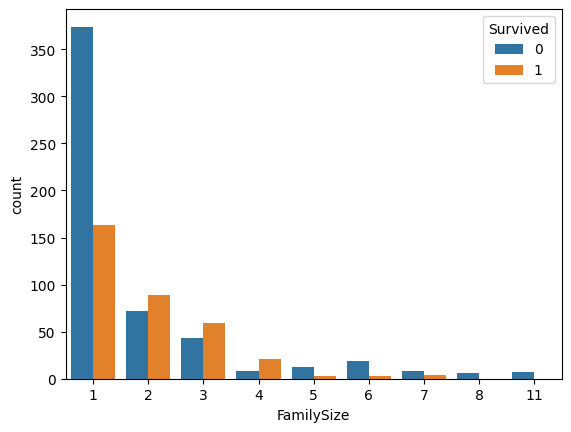

In [9]:
# 시각화
# FamilySize열에는 자신을 포함한 가족 구성원 수가 들어감
data['FamilySize'] = data['Parch'] + data['SibSp'] + 1
train['FamilySize'] = data['FamilySize'][:len(train)]
test['FamilySize'] = data['FamilySize'][len(train):]

import seaborn as sns
sns.countplot(x = 'FamilySize', data=train, hue='Survived')

1. Family size가 5 이상일 때부터 사망률이 생존률을 넘어선다.(생존률이 낮아진다)
2. Family size가 1인 사람이 압도적으로 많다.
-> 두 사실 모두 예측에 영향을 줄 수 있음 

In [10]:
# 구성원이 혼자인 경우를 새로운 feature로 만든다.

data['IsAlone'] = 0
data.loc[data['FamilySize']==1, 'IsAlone'] = 1
train['IsAlone'] = data['IsAlone'][:len(train)]
test['IsAlone'] = data['IsAlone'][len(train):]

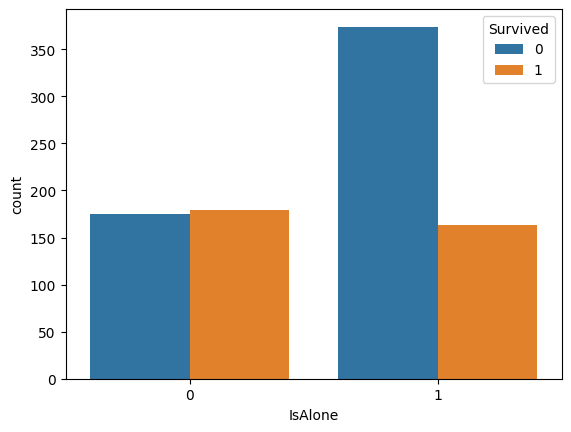

In [11]:
import matplotlib.pyplot as plt
sns.countplot(x = 'IsAlone', hue = 'Survived', data = train)
plt.legend(loc = 'upper right', title = 'Survived')